# Creating a generalizable election lexicon

The ideal lexicon is generalizable, but the election lexicons of Chapter 4 left much to be desired.
The lexicons went from being too general to being too specific, and everything in-between.

In this notebook, we create a generalizable lexicon.
The perfect lexicon has two qualities:

1. It is as large as possibe, and
2. It has as high an Average Precision (AP) as possible

First, we set up the data for this notebook.

In [1]:
import importlib
import json
import math
import os
import sys
import re

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon, Rectangle
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
from scipy.stats import shapiro, ttest_rel

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path = list(set(sys.path))

from eventdt.objects.exportable import Exportable
from multiplex import drawable
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))

names = { 'specificity': 'Domain Specificity', 'rank': 'Rank Difference', 'rank-50': 'Rank Difference',
          'tf-idf': 'TF-ICF', 'tf-dcf': 'TF-DCF', 'ef-idf-entropy': 'EF-ICF-Entropy' }

original_terms = os.path.expanduser('~/DATA/c4-ate/elections/analyses/verified')
original_common = os.path.expanduser('~/DATA/c4-ate/elections/analyses/verified/results-common-new-ap')
original_results = os.path.expanduser('~/DATA/c4-ate/elections/analyses/verified/results-states-new-ap')
original_results = os.path.expanduser('~/DATA/c4-ate/elections/analyses/verified/results-1000')
original_400 = os.path.expanduser('~/DATA/c4-ate/elections/analyses/verified/results-400')

reranked_terms = os.path.expanduser('~/DATA/c4-ate/elections/analyses/reranked')
reranked_common = os.path.expanduser('~/DATA/c4-ate/elections/analyses/reranked/results-common')
reranked_results = os.path.expanduser('~/DATA/c4-ate/elections/analyses/reranked/results')
reranked_400 = os.path.expanduser('~/DATA/c4-ate/elections/analyses/reranked/results-400')

bootstrapped_terms = os.path.expanduser('~/DATA/c4-ate/elections/analyses/bootstrapped')
bootstrapped_common = os.path.expanduser('~/DATA/c4-ate/elections/analyses/bootstrapped/results-common')
bootstrapped_results = os.path.expanduser('~/DATA/c4-ate/elections/analyses/bootstrapped/results')

## Recap on original results

The next code cell loads all original lexicons and their results into a dataframe.
All lexicons use only tweets by verified users to construct a more formal lexicon that informs journalists.
To that end, the priority is to report with accuracy, without words, like *baller* in football, that express opinions.

The best-performing lexicon, Rank Difference with a cut-off frequency of 50, `rank-50`, performs better than any other algorithm, with a precision of 0.355 and an AP of 0.465.

In [2]:
# create the dataframe
odf = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@200', 'p@400', 'p@k', 'terms', 'precise' ])

files = os.listdir(original_results) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(original_terms, file)) as data, open(os.path.join(original_results, file)) as results:
        data, results = json.loads(data.readline()), json.loads(results.readline())
        method = pattern.findall(file)[0]
        
        # load the actual lexicon
        terms = [ term['term'] for term in data['terms'] ]
        
        # get the summary results
        summary = results['results']['summary']
        pk = results['results']['p@k']
        precise = results['results']['precise']
        
        # insert it all in the dataframe
        odf.loc[len(odf)] = { 'method': method,
                              'ap': summary['average precision'], 'precision': summary['precision'],
                              'recall': summary['recall'], 'f1': summary['f1'],
                              'p@50': pk['50'], 'p@100': pk['100'], 'p@200': pk['200'], 'p@400': pk['400'], 'p@k': pk,
                              'terms': terms, 'precise': precise }

odf = odf.sort_values(by=['ap'], ascending=False)
odf = odf.set_index('method', drop=True)
odf

,precision,recall,f1,ap,p@50,p@100,p@200,p@400,p@k,terms,precise
method,,,,,,,,,,,
rank,0.213,0.181896,0.196223,0.063403,0.52,0.42,0.350,0.3025,"{'1': 1, '2': 1.0, '3': 0.6666666666666666, '4...","[administr, president-elect, inaugur, pardon, ...","{'administr': True, 'president-elect': True, '..."
tf-idf,0.213,0.181896,0.196223,0.055574,0.46,0.38,0.320,0.2550,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, president-elect, say, administr,...","{'elect': True, 'vote': True, 'president-elect..."
tf-dcf,0.214,0.182750,0.197144,0.054834,0.44,0.38,0.305,0.2600,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, president-elect, vote, trump, say, pre...","{'elect': True, 'president-elect': True, 'vote..."
rank-50,0.195,0.166524,0.179641,0.054420,0.44,0.38,0.355,0.2775,"{'1': 1, '2': 0.5, '3': 0.6666666666666666, '4...","[president-elect, inaugur, pardon, presidenti,...","{'president-elect': True, 'inaugur': False, 'p..."
specificity,0.179,0.152861,0.164901,0.037929,0.30,0.27,0.280,0.2450,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[inaugur, pro-trump, incit, runoff, recount, o...","{'inaugur': False, 'pro-trump': False, 'incit'..."
ef-idf-entropy,0.145,0.123826,0.133579,0.027730,0.24,0.28,0.260,0.2050,"{'1': 0, '2': 0.5, '3': 0.3333333333333333, '4...","[conced, pardon, fump, donald, recount, hunter...","{'conced': False, 'pardon': True, 'fump': Fals..."


In elections, the five algorithms form three, much clearer groups than in football.
Domain Specificity and Rank Difference, both highly-specific, share some overlap between them.
The general methods, TF-ICF and TF-DCF, share a lot of overlap, as expected of their similar metrics.
EF-ICF-Entropy remains isolated.

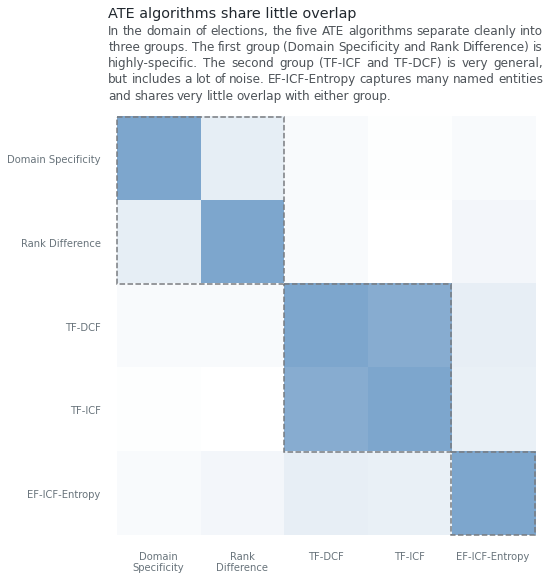

In [3]:
# prepare the data
focus = [ 'specificity', 'rank-50', 'tf-dcf', 'tf-idf', 'ef-idf-entropy' ] # methods to show
linestyle = { 'linewidth': 1.5, 'edgecolor': 'C3', 'facecolor': 'none', 'linestyle': '--' }
_df = odf[odf.index.isin(focus)]
use = 200 # the number of terms to use
intersection = [
    [ len(set(_df.loc[i].terms[:use]).intersection(set(_df.loc[j].terms[:use])))
        for j in focus ]
    for i in focus ]

# create a style (mainly, the color map)
_min, _max = (125, 166, 205, 0), (125, 166, 205, 255)
samples = 100
rgba = np.ones((samples, 4))
for i in range(4):
    rgba[:, i] = np.linspace(_min[i]/255, _max[i]/255, samples)
cmap = ListedColormap(rgba)

# draw the visualization
figure = plt.figure(figsize=(8, 8))
viz = drawable.Drawable(figure)
viz.imshow(intersection, cmap=cmap)

# add a border around the three groups
xlim, ylim = viz.get_xlim(), viz.get_ylim()
pad = 0.1
viz.set_xlim(xlim[0]-pad, xlim[1]+pad)
viz.set_ylim(ylim[0]+pad, ylim[1]-pad)
viz.add_patch(Rectangle((-0.5, -0.5), 2, 2, **linestyle))
viz.add_patch(Rectangle((1.5, 1.5), 2, 2, **linestyle))
viz.add_patch(Rectangle((3.5, 3.5), 1, 1, **linestyle))

# finalize the visualization
viz.grid(False)
viz.set_xticks(range(len(focus)))
viz.set_xticklabels([ names.get(method, method).replace(' ', '\n', 1) for method in focus ])
viz.axes.spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom=False, labelbottom=True)
viz.set_yticks(range(len(focus)))
viz.set_yticklabels([ names.get(method, method) for method in focus ])
viz.set_axisbelow(True)
viz.set_title("ATE algorithms share little overlap", loc='left')
viz.set_caption(f"""In the domain of elections, the five ATE algorithms separate cleanly into three groups.
                    The first group (Domain Specificity and Rank Difference) is highly-specific.
                    The second group (TF-ICF and TF-DCF) is very general, but includes a lot of noise.
                    EF-ICF-Entropy captures many named entities and shares very little overlap with either group.""",
                align='justify')
viz.savefig('../exports/4.4-base-lexicon-overlap.png', dpi=300, bbox_inches='tight')

Neither method generates a good lexicon in isolation.

Domain Specificity's and Rank Difference's lexicons are too specific.
Unlike in football matches, the two algorithms, especially Rank Difference, avoid named entities because the main characters had already been popular.
While many the terms are correct, they are also *too* specific.
We cannot expect an *insurrection* to follow every election.
At the same time, the two algorithms miss many important terms, like *vote*, *election* and *president*.
Therefore the two methods are not very generalizable.

TF-ICF's and TF-DCF's lexicons are very general.
Normally, that would be a virtue because general terms, like *vote*, *election* and *president*, make the lexicon transferable.
However, the incorrect terms a problem: they are too noisy, with members like *say* and *think*.

EF-ICF-Entropy, which we used in Chapter 5 to build timelines of football matches, avoids noise, but without construcing a very transferable list.
Our method's lexicon balances general and specific terms, but includes many named entities, such as *Donald Trump* and *Rudy Giuliani*, who won't be relevant to other elections.

## Semantic re-ranking to remove noise

Noise inundates TF-ICF's lexicon, but the general method is still the most appropriate for event modeling and mining.
No other lexicon, apart from TF-DCF's, is as generalizable and transferable to other elections.
EF-ICF-Entropy, however, is fit to remove noise.

In [4]:
# create the dataframe
rdf = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@200', 'p@400', 'p@k', 'terms', 'precise', 'precise_n' ])

files = os.listdir(reranked_results) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(reranked_terms, file)) as data, open(os.path.join(reranked_results, file)) as results:
        data, results = json.loads(data.readline()), json.loads(results.readline())
        method = pattern.findall(file)[0]
        
        # get the terms and the ones that are correct
        terms = results['pcmd']['terms']
        precise = results['results']['precise']
        precise_n = [ term for term, is_precise in results['results']['precise'].items() if is_precise ]
        
        # get the summary results
        summary = results['results']['summary']
        pk = results['results']['p@k']
        
        # insert it all in the dataframe
        rdf.loc[len(rdf)] = { 'method': method,
                              'ap': summary['average precision'], 'precision': summary['precision'],
                              'precise_n': len(precise_n),
                              'recall': summary['recall'], 'f1': summary['f1'],
                              'p@50': pk['50'], 'p@100': pk['100'], 'p@200': pk['200'],
                              'p@400': (pk['400'] if '400' in pk else summary['precision']), 'p@k': pk,
                              'terms': terms, 'precise': precise }

rdf = rdf.sort_values(by=['ap'], ascending=False)
rdf = rdf.set_index('method', drop=True)
rdf

,precision,recall,f1,ap,p@50,p@100,p@200,p@400,p@k,terms,precise,precise_n
method,,,,,,,,,,,,
tf-idf-k1000-ef-idf-entropy-multiply,0.213,0.181896,0.196223,0.065955,0.62,0.45,0.380,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ...",213
tf-idf-k1000-ef-idf-entropy-harmonic,0.213,0.181896,0.196223,0.064739,0.60,0.44,0.370,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, administr, campaign, par...","{'elect': True, 'vote': True, 'presid': True, ...",213
tf-idf-k500-ef-idf-entropy-multiply,0.240,0.102477,0.143627,0.048166,0.64,0.45,0.370,0.2625,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ...",120
rank-50-k1000-ef-idf-entropy-multiply,0.195,0.166524,0.179641,0.047416,0.36,0.32,0.270,0.2700,"{'1': 1, '2': 0.5, '3': 0.6666666666666666, '4...","[pardon, conced, recount, ralli, elector, over...","{'pardon': True, 'conced': False, 'recount': T...",195
rank-50-k500-ef-idf-entropy-multiply,0.248,0.105892,0.148414,0.036354,0.38,0.33,0.325,0.2725,"{'1': 1, '2': 0.5, '3': 0.6666666666666666, '4...","[pardon, conced, recount, ralli, elector, over...","{'pardon': True, 'conced': False, 'recount': T...",124
rank-50-k500-ef-idf-entropy-normal,0.248,0.105892,0.148414,0.033395,0.34,0.29,0.325,0.2725,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...","[conced, pardon, recount, joe, ralli, landslid...","{'conced': False, 'pardon': True, 'recount': T...",124
tf-idf-k200-ef-idf-entropy-multiply,0.320,0.054654,0.093363,0.031078,0.62,0.42,0.320,0.3200,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ...",64
rank-50-k200-ef-idf-entropy-multiply,0.355,0.060632,0.103574,0.025594,0.38,0.35,0.355,0.3550,"{'1': 1, '2': 0.5, '3': 0.3333333333333333, '4...","[pardon, conced, ralli, elector, recount, over...","{'pardon': True, 'conced': False, 'ralli': Fal...",71


Comparing:
tf-idf
tf-idf-k1000-ef-idf-entropy-multiply


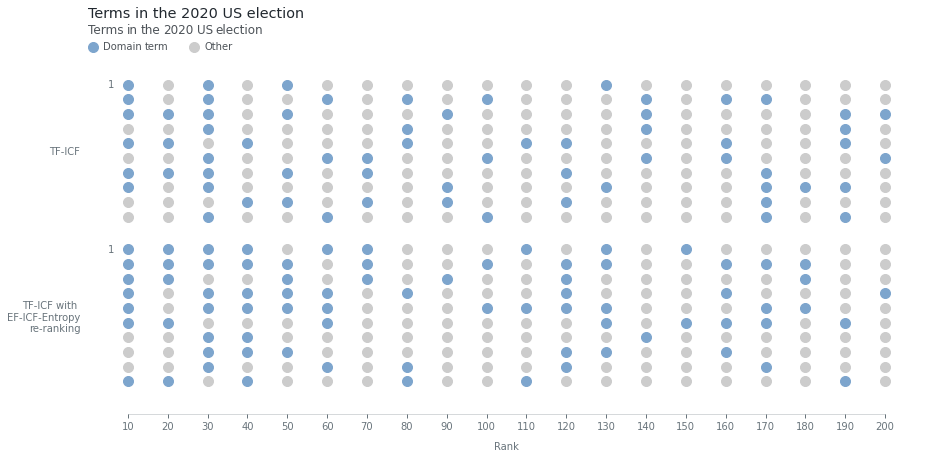

In [5]:
# create the styles
style = { 's': 100, 'color': 'C5', 'label': 'Other' }
correct = dict(style)
correct.update({ 'color': 'C1', 'label': 'Domain term' })

# prepare the data
original = odf.loc['tf-idf']
reranked = rdf.iloc[0]

t0, c0 = original.terms[:200], original.precise
t1, c1 = reranked.terms[:200], reranked.precise

print(f"\033[1mComparing:\033[0m")
print(original.name)
print(reranked.name)

populations = [
    [ correct if c0[term] else style for term in t0 ],
    [ correct if c1[term] else style for term in t1 ],
]

# draw the visualization
viz = drawable.Drawable(plt.figure(figsize=(15, 6.67)))
viz.draw_population(populations[0], 10, 'TF-ICF', height=0.8, show_start=True)
viz.draw_population(populations[1], 10, 'TF-ICF with \nEF-ICF-Entropy\nre-ranking', height=0.8, show_start=True)

# finalize the plot
viz.set_xlabel('Rank')
viz.set_title('Terms in the 2020 US election', loc='left')
viz.set_caption(f"""Terms in the 2020 US election""",
                align='justify')
viz.savefig('../exports/6.2-reranking-order.png', dpi=300, bbox_inches='tight')

In [6]:
original = odf.loc['tf-idf']
reranked = rdf.iloc[0]

# t1 is the list of baseline terms, t2 is the list of bootstrapped terms
t1, t2 = original.terms, reranked.terms

# r1 is the ranked list of baseline terms, r2 is the ranked list of bootstrapped terms
r1, r2 = { term: r + 1 for r, term in enumerate(t1) }, { term: r + 1 for r, term in enumerate(t2) }

# if the difference is positive, it means that a term is lower in the baseline than in the bootstrapped
common = set(t2).intersection(set(t1))
diff = { term: r1[term] - r2[term] for term in common }

print(f"\033[1mComparing:\033[0m { original.name } ⇒ { reranked.name }")
print()

print(f"\033[1mLargest climbs\033[0m")
for term in sorted(diff, key=diff.get, reverse=True)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

print(f"\033[1mLargest drops\033[0m")
for term in sorted(diff, key=diff.get, reverse=False)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

Comparing: tf-idf ⇒ tf-idf-k1000-ef-idf-entropy-multiply

Largest climbs
clemenc: 991 ⇒ 381 (610)
wife: 992 ⇒ 382 (610)
landslid: 952 ⇒ 345 (607)
affirm: 987 ⇒ 380 (607)
lock: 971 ⇒ 377 (594)
capitol: 946 ⇒ 355 (591)
proof: 969 ⇒ 379 (590)
financi: 959 ⇒ 378 (581)
hous: 931 ⇒ 354 (577)
secret: 944 ⇒ 374 (570)

Largest drops
say: 4 ⇒ 384 (-380)
president-elect: 3 ⇒ 383 (-380)
're: 9 ⇒ 385 (-376)
peopl: 14 ⇒ 386 (-372)
get: 20 ⇒ 387 (-367)
take: 29 ⇒ 388 (-359)
think: 32 ⇒ 389 (-357)
make: 34 ⇒ 390 (-356)
've: 38 ⇒ 391 (-353)
want: 49 ⇒ 392 (-343)



In [7]:
# t1 is the list of baseline terms, t2 is the list of bootstrapped terms
t1, t2 = original.terms, reranked.terms[:100]

# r1 is the ranked list of baseline terms, r2 is the ranked list of bootstrapped terms
r1, r2 = { term: r + 1 for r, term in enumerate(t1) }, { term: r + 1 for r, term in enumerate(t2) }

# if the difference is positive, it means that a term is lower in the baseline than in the bootstrapped
common = set(t2).intersection(set(t1))
diff = { term: r1[term] - r2[term] for term in common }

print(f"\033[1mComparing:\033[0m { original.name } ⇒ { reranked.name }")
print()

print(f"\033[1mLargest climbs into the top { len(t2) }\033[0m")
for term in sorted(diff, key=diff.get, reverse=True)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

Comparing: tf-idf ⇒ tf-idf-k1000-ef-idf-entropy-multiply

Largest climbs into the top 100
uselect: 352 ⇒ 99 (253)
counti: 323 ⇒ 92 (231)
biden: 243 ⇒ 57 (186)
attorney: 278 ⇒ 98 (180)
congratul: 265 ⇒ 86 (179)
chief: 238 ⇒ 81 (157)
riot: 247 ⇒ 96 (151)
statement: 242 ⇒ 95 (147)
senat: 209 ⇒ 62 (147)
speech: 199 ⇒ 52 (147)



In [8]:
# t1 is the list of baseline terms, t2 is the list of bootstrapped terms
t1, t2 = original.terms[:100], reranked.terms

# r1 is the ranked list of baseline terms, r2 is the ranked list of bootstrapped terms
r1, r2 = { term: r + 1 for r, term in enumerate(t1) }, { term: r + 1 for r, term in enumerate(t2) }

# if the difference is positive, it means that a term is lower in the baseline than in the bootstrapped
common = set(t2).intersection(set(t1))
diff = { term: r1[term] - r2[term] for term in common }

print(f"\033[1mComparing:\033[0m { original.name } ⇒ { reranked.name }")
print()

print(f"\033[1mLargest drops from the top { len(t1) }\033[0m")
for term in sorted(diff, key=diff.get, reverse=False)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

Comparing: tf-idf ⇒ tf-idf-k1000-ef-idf-entropy-multiply

Largest drops from the top 100
say: 4 ⇒ 384 (-380)
president-elect: 3 ⇒ 383 (-380)
're: 9 ⇒ 385 (-376)
peopl: 14 ⇒ 386 (-372)
get: 20 ⇒ 387 (-367)
take: 29 ⇒ 388 (-359)
think: 32 ⇒ 389 (-357)
make: 34 ⇒ 390 (-356)
've: 38 ⇒ 391 (-353)
want: 49 ⇒ 392 (-343)



## Bootstrapping's results

In [9]:
# create the dataframe
bdf = pd.DataFrame(columns=[ 'method', 'seed', 'keep', 'choose', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@200', 'p@400', 'p@k', 'terms', 'precise' ])

for file in os.listdir(bootstrapped_results):
    with open(os.path.join(bootstrapped_terms, file)) as data, open(os.path.join(bootstrapped_results, file)) as results:
        # decode the data and results
        data, results = json.loads(data.readline()), json.loads(results.readline())
        
        # load the data setup
        method = Exportable.get_class(data['pcmd']['method'])
        seed = len(data['pcmd']['seed'])
        keep = data['pcmd']['keep']
        choose = 'max' if 'max' in data['pcmd']['choose'] else 'mean'
        
        # get the terms and the ones that are correct
        terms = results['pcmd']['terms']
        precise = results['results']['precise']
        
        # load the summary results
        summary = results['results']['summary']
        precision = results['results']['summary']['precision']
        recall = results['results']['summary']['recall']
        f1 = results['results']['summary']['f1']
        ap = results['results']['summary']['average precision']
        pk = results['results']['p@k']
        
        bdf.loc[len(bdf)] = { 'method': method, 'seed': seed, 'keep': keep, 'choose': choose,
                              'precision': precision, 'recall': recall, 'f1': f1,
                              'ap': ap, 'p@50': pk['50'], 'p@100': pk['100'], 'p@200': pk['200'], 'p@400': pk['400'], 'p@k': pk,
                              'terms': terms, 'precise': precise }

bdf = bdf.sort_values(by=[ 'ap' ], ascending=False)
bdf = bdf.reset_index(drop=True)
bdf.head()

,method,seed,keep,choose,precision,recall,f1,ap,p@50,p@100,p@200,p@400,p@k,terms,precise
0,ChiBootstrapper,6,10,mean,0.2725,0.093083,0.138765,0.055928,0.68,0.57,0.420,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."
1,ChiBootstrapper,6,1,mean,0.2725,0.093083,0.138765,0.055407,0.66,0.55,0.415,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."
2,ChiBootstrapper,7,10,mean,0.2725,0.093083,0.138765,0.054671,0.66,0.56,0.420,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."
3,ChiBootstrapper,5,10,mean,0.2725,0.093083,0.138765,0.054465,0.64,0.57,0.420,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, administr, resul...","{'elect': True, 'vote': True, 'presid': True, ..."
4,ChiBootstrapper,4,10,mean,0.2725,0.093083,0.138765,0.053964,0.62,0.57,0.420,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, pardon, result, count, e...","{'elect': True, 'vote': True, 'presid': True, ..."


To facilitate the comparison, make bootstrapping's contributions even clearer, we load the results of the baselines and the re-ranked terms, but considering only the top 400 terms.
Consequently, the AP values will be comparable with bootstrapping's.

In [10]:
# create the dataframe
odf_400 = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@200', 'p@400', 'p@k', 'terms', 'precise' ])

files = os.listdir(original_400) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(original_terms, file)) as data, open(os.path.join(original_400, file)) as results:
        data, results = json.loads(data.readline()), json.loads(results.readline())
        method = pattern.findall(file)[0]
        
        # load the actual lexicon
        terms = [ term['term'] for term in data['terms'] ]
        
        # get the summary results
        summary = results['results']['summary']
        pk = results['results']['p@k']
        precise = results['results']['precise']
        
        # insert it all in the dataframe
        odf_400.loc[len(odf_400)] = { 'method': method,
                                      'ap': summary['average precision'], 'precision': summary['precision'],
                                      'recall': summary['recall'], 'f1': summary['f1'],
                                      'p@50': pk['50'], 'p@100': pk['100'], 'p@200': pk['200'], 'p@400': pk['400'], 'p@k': pk,
                                      'terms': terms, 'precise': precise }

odf_400 = odf_400.sort_values(by=['ap'], ascending=False)
odf_400 = odf_400.set_index('method', drop=True)
odf_400

,precision,recall,f1,ap,p@50,p@100,p@200,p@400,p@k,terms,precise
method,,,,,,,,,,,
rank,0.3025,0.103330,0.154042,0.043578,0.52,0.42,0.350,0.3025,"{'1': 1, '2': 1.0, '3': 0.6666666666666666, '4...","[administr, president-elect, inaugur, pardon, ...","{'administr': True, 'president-elect': True, '..."
rank-50,0.2775,0.094791,0.141311,0.038552,0.44,0.38,0.355,0.2775,"{'1': 1, '2': 0.5, '3': 0.6666666666666666, '4...","[president-elect, inaugur, pardon, presidenti,...","{'president-elect': True, 'inaugur': False, 'p..."
tf-idf,0.2550,0.087105,0.129854,0.033906,0.46,0.38,0.320,0.2550,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, president-elect, say, administr,...","{'elect': True, 'vote': True, 'president-elect..."
tf-dcf,0.2600,0.088813,0.132400,0.033232,0.44,0.38,0.305,0.2600,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, president-elect, vote, trump, say, pre...","{'elect': True, 'president-elect': True, 'vote..."
specificity,0.2450,0.083689,0.124761,0.023118,0.30,0.27,0.280,0.2450,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[inaugur, pro-trump, incit, runoff, recount, o...","{'inaugur': False, 'pro-trump': False, 'incit'..."
ef-idf-entropy,0.2050,0.070026,0.104392,0.018171,0.24,0.28,0.260,0.2050,"{'1': 0, '2': 0.5, '3': 0.3333333333333333, '4...","[conced, pardon, fump, donald, recount, hunter...","{'conced': False, 'pardon': True, 'fump': Fals..."


In [11]:
# create the dataframe
rdf_400 = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@200', 'p@400', 'p@k', 'terms', 'precise' ])

files = os.listdir(reranked_400) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(reranked_400, file)) as results:
        results = json.loads(results.readline())
        method = pattern.findall(file)[0]
        
        # load the actual lexicon
        terms = [ term['term'] for term in data['terms'] ]
        
        # get the summary results
        summary = results['results']['summary']
        pk = results['results']['p@k']
        precise = results['results']['precise']
        
        # insert it all in the dataframe
        rdf_400.loc[len(rdf_400)] = { 'method': method,
                                      'ap': summary['average precision'], 'precision': summary['precision'],
                                      'recall': summary['recall'], 'f1': summary['f1'],
                                      'p@50': pk['50'], 'p@100': pk['100'], 'p@200': pk['200'],
                                      'p@400': pk['400'] if '400' in pk else None, 'p@k': pk,
                                      'terms': terms, 'precise': precise }

rdf_400 = rdf_400.sort_values(by=['ap'], ascending=False)
rdf_400 = rdf_400.set_index('method', drop=True)
rdf_400

,precision,recall,f1,ap,p@50,p@100,p@200,p@400,p@k,terms,precise
method,,,,,,,,,,,
tf-idf-k1000-ef-idf-entropy-multiply,0.2725,0.093083,0.138765,0.046006,0.62,0.45,0.380,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, president-elect, vote, trump, say, pre...","{'elect': True, 'vote': True, 'presid': True, ..."
tf-idf-k500-ef-idf-entropy-multiply,0.2625,0.089667,0.133673,0.044883,0.64,0.45,0.370,0.2625,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, president-elect, vote, trump, say, pre...","{'elect': True, 'vote': True, 'presid': True, ..."
tf-idf-k1000-ef-idf-entropy-harmonic,0.2725,0.093083,0.138765,0.044790,0.60,0.44,0.370,0.2725,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, president-elect, vote, trump, say, pre...","{'elect': True, 'vote': True, 'presid': True, ..."
rank-50-k500-ef-idf-entropy-multiply,0.2725,0.093083,0.138765,0.033028,0.38,0.33,0.325,0.2725,"{'1': 1, '2': 0.5, '3': 0.6666666666666666, '4...","[elect, president-elect, vote, trump, say, pre...","{'pardon': True, 'conced': False, 'recount': T..."
tf-idf-k200-ef-idf-entropy-multiply,0.3200,0.054654,0.093363,0.031078,0.62,0.42,0.320,None,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, president-elect, vote, trump, say, pre...","{'elect': True, 'vote': True, 'presid': True, ..."
rank-50-k1000-ef-idf-entropy-multiply,0.2700,0.092229,0.137492,0.030758,0.36,0.32,0.270,0.27,"{'1': 1, '2': 0.5, '3': 0.6666666666666666, '4...","[elect, president-elect, vote, trump, say, pre...","{'pardon': True, 'conced': False, 'recount': T..."
rank-50-k500-ef-idf-entropy-normal,0.2725,0.093083,0.138765,0.030069,0.34,0.29,0.325,0.2725,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...","[elect, president-elect, vote, trump, say, pre...","{'conced': False, 'pardon': True, 'recount': T..."
rank-50-k200-ef-idf-entropy-multiply,0.3550,0.060632,0.103574,0.025594,0.38,0.35,0.355,None,"{'1': 1, '2': 0.5, '3': 0.3333333333333333, '4...","[elect, president-elect, vote, trump, say, pre...","{'pardon': True, 'conced': False, 'ralli': Fal..."


Changes from the TF-ICF lexicon to the re-ranked and bootstrapped one:

- Average precision almost doubles, from 2.39% to 4.71%
- P@50 increases from 46% to 68%
- P@100 increases from 38% to 57%
- P@200 increases from 32% to 42% (the best result increases to 42.5%)

Comparing:
tf-idf
tf-idf-k1000-ef-idf-entropy-multiply
ChiBootstrapper with 6 seeds and keeping 10 at each iteration


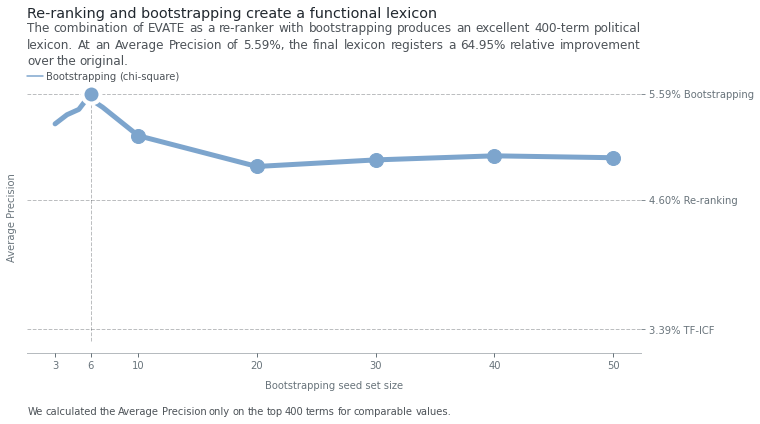

In [25]:
# prepare the data
_df = bdf.sort_values(by=[ 'seed' ])
original = odf_400.loc['tf-idf']
reranked = rdf_400.iloc[0]
bootstrapped = bdf.iloc[0]

print(f"\033[1mComparing:\033[0m")
print(original.name)
print(reranked.name)
print(f"{ bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")

metric = 'ap'
annotations = {
    original[metric]: f"{ '{:.2f}'.format(round(original[metric], 4) * 100) }% TF-ICF",
    reranked[metric]: f"{ '{:.2f}'.format(round(reranked[metric], 4) * 100) }% Re-ranking",
    bootstrapped[metric]: f"{ '{:.2f}'.format(round(bootstrapped[metric], 4) * 100) }% Bootstrapping",
}

# create a style for the precision
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 5, 'with_legend': True,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal(), ] }
marker_style = { 'marker': 'o', 'markersize': 14 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 6 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 18, 'markeredgewidth': 4, 'markeredgecolor': 'C4', 'zorder': 7 }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'pad': 0, 'facecolor': '#ffffff99' }

# draw the visualization
figure = plt.figure(figsize=(11, 5))
viz = drawable.Drawable(figure)
_data = _df[(_df.method == 'ChiBootstrapper') & ((_df.seed < 10) | (_df.seed % 10 == 0)) & (_df.seed <= 50)]
viz.draw_time_series(_data.seed, _data[metric], 'Bootstrapping (chi-square)', color='C1', **style)
viz.scatter(_data[_data.seed >= 10].seed, _data[_data.seed >= 10][metric], color='C1', **scatter_style)

# finalize the visualization
viz.set_xticks(list(range(10, max(_data.seed) + 1, 10)) + [ min(_data.seed), bootstrapped.seed ] )
viz.set_xlabel('Bootstrapping seed set size')
viz.set_yticks([ ])
yticklabels = [ '{:.2f}'.format(round(tick * 100, 4)) for tick in viz.get_yticks() ]
viz.set_yticklabels([ f"{ label }%" for label in yticklabels ])
viz.set_ylabel('Average Precision')
viz.set_axisbelow(True)

# add the annotations
ax2 = viz.axes.twinx()
xlim = viz.get_xlim()
for annotation in annotations:
    viz.hlines(annotation, xmin=xlim[0], xmax=xlim[1], **line_style)
ax2.set_xlim(xlim)
ax2.set_yticks(list(annotations.keys()))
ax2.set_yticklabels(list(annotations.values()))
# ax2.set_ylim(min(annotations)*0.9, max(annotations)*1.1)
ax2.grid(False)

# annotate the best point
viz.vlines(bootstrapped.seed, ymin=viz.get_ylim()[0], ymax=bootstrapped[metric], **line_style)
viz.plot(bootstrapped.seed, bootstrapped[metric], color='C1', **annotation_marker_style)
ax2.set_ylim(viz.get_ylim())

# add the title and captions
viz.set_title("Re-ranking and bootstrapping create a functional lexicon", loc='left')
viz.set_caption(f"""The combination of EVATE as a re-ranker with bootstrapping produces an excellent 400-term political lexicon.
                    At an Average Precision of { '{:.2f}'.format(round(bootstrapped[metric] * 100, 4)) }%, the final lexicon registers a { '{:.2f}'.format(round((bootstrapped[metric] / original[metric] - 1) * 100, 4)) }% relative improvement over the original.""",
                align='justify')
viz.set_footnote("We calculated the Average Precision only on the top 400 terms for comparable values.")
viz.savefig('../exports/4.4-bootstrapping-politics.png', dpi=300, bbox_inches='tight')

Comparing:
tf-idf
tf-idf-k1000-ef-idf-entropy-multiply
ChiBootstrapper with 6 seeds and keeping 10 at each iteration


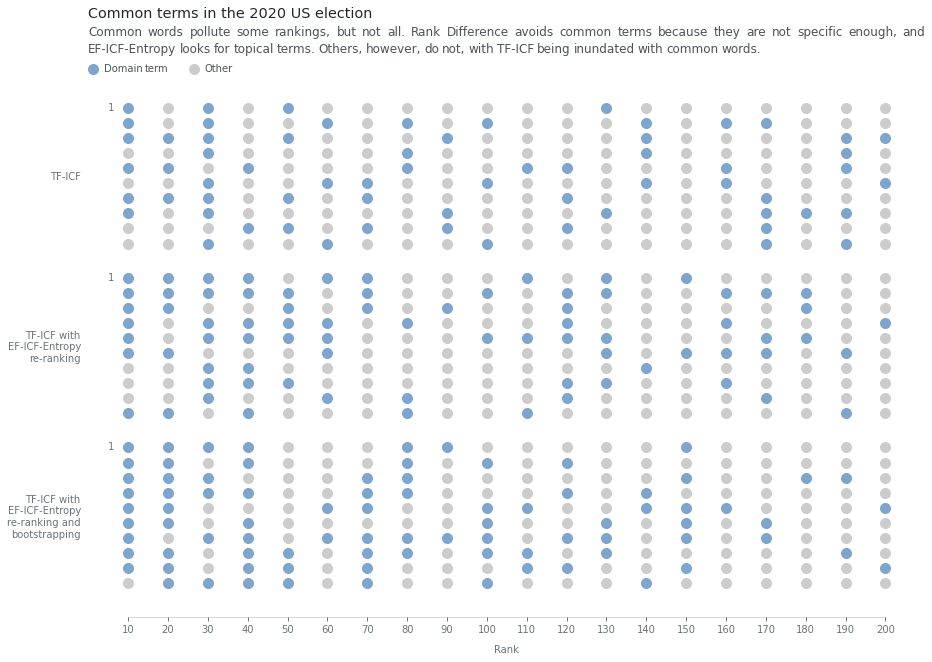

In [13]:
# create the styles
style = { 's': 100, 'color': 'C5', 'label': 'Other' }
correct = dict(style)
correct.update({ 'color': 'C1', 'label': 'Domain term' })

# prepare the data
original = odf.loc['tf-idf']
reranked = rdf.iloc[0]
bootstrapped = bdf.iloc[0]

t0, c0 = original.terms[:200], original.precise
t1, c1 = reranked.terms[:200], reranked.precise
t2, c2 = bootstrapped.terms[:200], bootstrapped.precise

t0, c0 = original.terms[:200], original.precise
t1, c1 = reranked.terms[:200], reranked.precise
t2, c2 = bootstrapped.terms[:200], bootstrapped.precise

print(f"\033[1mComparing:\033[0m")
print(original.name)
print(reranked.name)
print(f"{ bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")

populations = [
    [ correct if c0[term] else style for term in t0 ],
    [ correct if c1[term] else style for term in t1 ],
    [ correct if c2[term] else style for term in t2 ],
]

# draw the visualization
viz = drawable.Drawable(plt.figure(figsize=(15, 10)))
viz.draw_population(populations[0], 10, 'TF-ICF', height=0.8, show_start=True)
viz.draw_population(populations[1], 10, 'TF-ICF with\nEF-ICF-Entropy\nre-ranking', height=0.8, show_start=True)
viz.draw_population(populations[2], 10, 'TF-ICF with\nEF-ICF-Entropy\nre-ranking and\nbootstrapping', height=0.8, show_start=True)

# finalize the plot
viz.set_xlabel('Rank')
viz.set_title('Common terms in the 2020 US election', loc='left')
viz.set_caption(f"""Common words pollute some rankings, but not all.
                    Rank Difference avoids common terms because they are not specific enough, and EF-ICF-Entropy looks for topical terms.
                    Others, however, do not, with TF-ICF being inundated with common words.""",
                align='justify')
viz.savefig('../exports/6.2-bootstrapping-order.png', dpi=300, bbox_inches='tight')

In [14]:
# create the styles
style = { 's': 100, 'color': 'C5', 'label': 'Other' }
correct = dict(style)
correct.update({ 'color': 'C2', 'label': 'Domain term' })

# prepare the data - copy the names from the best-performing models
original = odf.loc['tf-idf']
reranked = rdf.iloc[0]
bootstrapped = bdf.iloc[0]

t0, c0 = original.terms[:200], original.precise
t1, c1 = reranked.terms[:200], reranked.precise
t2, c2 = bootstrapped.terms[:200], bootstrapped.precise

print(f"\033[1mComparing terms in:\033[0m")
print(original.name)
print(reranked.name)
print(f"{ bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")
print()

populations = [
    [ correct if c0[term] else style for term in t0 ],
    [ correct if c1[term] else style for term in t1 ],
    [ correct if c2[term] else style for term in t2 ],
]

print(f"P@50:  { round(original['p@50'], 2) } ⇒ { round(reranked['p@50'], 2) } ⇒ { round(bootstrapped['p@50'], 2) }")
print(f"P@100: { round(original['p@100'], 2) } ⇒ { round(reranked['p@100'], 2) } ⇒ { round(bootstrapped['p@100'], 2) }")
print(f"P@200: { round(original.precision, 4) } ⇒ { round(reranked.precision, 4) } ⇒ { round(bootstrapped['p@200'], 4) }")

Comparing terms in:
tf-idf
tf-idf-k1000-ef-idf-entropy-multiply
ChiBootstrapper with 6 seeds and keeping 10 at each iteration

P@50:  0.46 ⇒ 0.62 ⇒ 0.68
P@100: 0.38 ⇒ 0.45 ⇒ 0.57
P@200: 0.213 ⇒ 0.213 ⇒ 0.42


In [15]:
reranked = rdf.iloc[0]
bootstrapped = bdf.iloc[0]

# t1 is the list of baseline terms, t2 is the list of bootstrapped terms
t1, t2 = reranked.terms, bootstrapped.terms

# r1 is the ranked list of baseline terms, r2 is the ranked list of bootstrapped terms
r1, r2 = { term: r + 1 for r, term in enumerate(t1) }, { term: r + 1 for r, term in enumerate(t2) }

# if the difference is positive, it means that a term is lower in the baseline than in the bootstrapped
common = set(t2).intersection(set(t1))
diff = { term: r1[term] - r2[term] for term in common }

print(f"\033[1mComparing:\033[0m { reranked.name } ⇒ { bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")
print()

print(f"\033[1mLargest climbs\033[0m")
for term in sorted(diff, key=diff.get, reverse=True)[:20]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

print(f"\033[1mLargest drops\033[0m")
for term in sorted(diff, key=diff.get, reverse=False)[:20]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()


Comparing: tf-idf-k1000-ef-idf-entropy-multiply ⇒ ChiBootstrapper with 6 seeds and keeping 10 at each iteration

Largest climbs
mail: 359 ⇒ 23 (336)
affirm: 380 ⇒ 65 (315)
president-elect: 383 ⇒ 71 (312)
widespread: 326 ⇒ 22 (304)
suit: 342 ⇒ 56 (286)
retir: 362 ⇒ 93 (269)
winner: 285 ⇒ 35 (250)
counsel: 316 ⇒ 67 (249)
vice: 302 ⇒ 54 (248)
take: 388 ⇒ 142 (246)
power: 399 ⇒ 155 (244)
clemenc: 381 ⇒ 144 (237)
popular: 275 ⇒ 43 (232)
appeal: 258 ⇒ 38 (220)
dismiss: 249 ⇒ 33 (216)
son: 288 ⇒ 75 (213)
pro-trump: 400 ⇒ 197 (203)
cast: 216 ⇒ 13 (203)
project: 268 ⇒ 66 (202)
say: 384 ⇒ 185 (199)

Largest drops
biden: 57 ⇒ 380 (-323)
speech: 52 ⇒ 333 (-281)
uselect: 99 ⇒ 363 (-264)
speak: 123 ⇒ 368 (-245)
news: 68 ⇒ 300 (-232)
good: 73 ⇒ 302 (-229)
loser: 143 ⇒ 361 (-218)
today: 76 ⇒ 293 (-217)
statement: 95 ⇒ 308 (-213)
polit: 51 ⇒ 262 (-211)
fight: 64 ⇒ 274 (-210)
interview: 149 ⇒ 358 (-209)
report: 103 ⇒ 310 (-207)
live: 78 ⇒ 284 (-206)
talk: 127 ⇒ 331 (-204)
stori: 135 ⇒ 337 (-202)
big: 15

In [16]:
original = odf.loc['tf-idf']
bootstrapped = bdf.iloc[0]

# t1 is the list of baseline terms, t2 is the list of bootstrapped terms
t1, t2 = original.terms[:1000], bootstrapped.terms

# r1 is the ranked list of baseline terms, r2 is the ranked list of bootstrapped terms
r1, r2 = { term: r + 1 for r, term in enumerate(t1) }, { term: r + 1 for r, term in enumerate(t2) }

# if the difference is positive, it means that a term is lower in the baseline than in the bootstrapped
common = set(t2).intersection(set(t1))
diff = { term: r1[term] - r2[term] for term in common }

print(f"\033[1mComparing:\033[0m { original.name } ⇒ { bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")
print()

print(f"\033[1mLargest climbs\033[0m")
for term in sorted(diff, key=diff.get, reverse=True)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

newcomers = sorted([ term for term in t2 if term not in t1 ], key=t2.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:10]:
    print(f"{ term }: { t2.index(term) + 1 }")
print()

print(f"\033[1mLargest drops\033[0m")
for term in sorted(diff, key=diff.get, reverse=False)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

lost = sorted([ term for term in t1 if term not in t2 ], key=t1.index, reverse=False)
print(f"\033[1m{ len(lost) } lost\033[0m")
for term in lost[:10]:
    print(f"{ term }: { t1.index(term) + 1 }")
print()

Comparing: tf-idf ⇒ ChiBootstrapper with 6 seeds and keeping 10 at each iteration

Largest climbs
affirm: 987 ⇒ 65 (922)
mail: 877 ⇒ 23 (854)
clemenc: 991 ⇒ 144 (847)
vice: 869 ⇒ 54 (815)
proof: 969 ⇒ 196 (773)
retir: 862 ⇒ 93 (769)
suit: 814 ⇒ 56 (758)
capitol: 946 ⇒ 201 (745)
lock: 971 ⇒ 266 (705)
invok: 853 ⇒ 148 (705)

0 newcomers

Largest drops
report: 36 ⇒ 310 (-274)
look: 63 ⇒ 325 (-262)
're: 9 ⇒ 267 (-258)
've: 38 ⇒ 291 (-253)
come: 70 ⇒ 316 (-246)
today: 55 ⇒ 293 (-238)
polit: 30 ⇒ 262 (-232)
talk: 102 ⇒ 331 (-229)
make: 34 ⇒ 260 (-226)
good: 80 ⇒ 302 (-222)

600 lost
includ: 82
chang: 84
use: 87
happen: 90
case: 93
help: 94
continu: 95
point: 99
show: 103
expect: 109



In [17]:
original = odf.loc['ef-idf-entropy']
bootstrapped = bdf.iloc[0]

# t1 is the list of baseline terms, t2 is the list of bootstrapped terms
t1, t2 = original.terms, bootstrapped.terms

# r1 is the ranked list of baseline terms, r2 is the ranked list of bootstrapped terms
r1, r2 = { term: r + 1 for r, term in enumerate(t1) }, { term: r + 1 for r, term in enumerate(t2) }

# if the difference is positive, it means that a term is lower in the baseline than in the bootstrapped
common = set(t2).intersection(set(t1))
diff = { term: r1[term] - r2[term] for term in common }

print(f"\033[1mComparing:\033[0m { original.name } ⇒ { bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")
print()

print(f"\033[1mLargest climbs\033[0m")
for term in sorted(diff, key=diff.get, reverse=True)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

newcomers = sorted([ term for term in t2 if term not in t1 ], key=t2.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:10]:
    print(f"{ term }: { t2.index(term) + 1 }")
print()

print(f"\033[1mLargest drops\033[0m")
for term in sorted(diff, key=diff.get, reverse=False)[:10]:
    print(f"{ term }: { r1[term] } ⇒ { r2[term] } ({ diff[term] })")
print()

lost = sorted([ term for term in t1 if term not in t2 ], key=t1.index, reverse=False)
print(f"\033[1m{ len(lost) } lost\033[0m")
for term in lost[:10]:
    print(f"{ term }: { t1.index(term) + 1 }")
print()

Comparing: ef-idf-entropy ⇒ ChiBootstrapper with 6 seeds and keeping 10 at each iteration

Largest climbs
power: 1767 ⇒ 155 (1612)
see: 1871 ⇒ 286 (1585)
want: 1672 ⇒ 249 (1423)
say: 1452 ⇒ 185 (1267)
peopl: 1160 ⇒ 204 (956)
take: 993 ⇒ 142 (851)
make: 1096 ⇒ 260 (836)
mani: 1014 ⇒ 223 (791)
first: 774 ⇒ 85 (689)
winner: 715 ⇒ 35 (680)

9 newcomers
president-elect: 71
pro-trump: 197
get: 215
need: 234
know: 257
're: 267
thing: 268
way: 270
've: 291

Largest drops
traitor: 22 ⇒ 385 (-363)
biden: 27 ⇒ 380 (-353)
loser: 25 ⇒ 361 (-336)
landslid: 12 ⇒ 334 (-322)
uselect: 44 ⇒ 363 (-319)
speech: 37 ⇒ 333 (-296)
grift: 153 ⇒ 393 (-240)
hous: 135 ⇒ 374 (-239)
fuck: 148 ⇒ 369 (-221)
ralli: 11 ⇒ 211 (-200)

1553 lost
fump: 3
donald: 4
hunter: 6
joe: 7
georgia: 8
pennsylvania: 9
kamala: 10
melania: 13
harri: 16
newslett: 18



In [18]:
original = odf.loc['tf-idf']
reranked = rdf.iloc[0]
bootstrapped = bdf.iloc[0]

print(f"\033[1mComparing:\033[0m { original.name } ⇒ { reranked.name } ⇒ { bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")
print()

interest = [ 'authoritarian' ]
# terms = bdf[(bdf.seed == 6) & (bdf.keep == 1)].iloc[0].terms
for term in sorted(interest):
    if term not in bootstrapped.terms:
        print(f"{ term} not in list")
        continue
    print(f"{ term }: { original.terms.index(term) + 1  } ⇒ { reranked.terms.index(term) + 1  } ⇒ { bootstrapped.terms.index(term) + 1  }")

Comparing: tf-idf ⇒ tf-idf-k1000-ef-idf-entropy-multiply ⇒ ChiBootstrapper with 6 seeds and keeping 10 at each iteration

authoritarian not in list


## Common words

The process does more than make TF-ICF's lexicon topical.
It also greatly cleans the lexicon of noise.

In [19]:
# create the dataframe
odf_common = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@k', 'terms', 'precise' ])

files = os.listdir(original_common) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(original_terms, file)) as data, open(os.path.join(original_common, file)) as results:
        data, results = json.loads(data.readline()), json.loads(results.readline())
        method = pattern.findall(file)[0]
        
        # load the actual lexicon
        terms = [ term['term'] for term in data['terms'] ]
        
        # get the summary results
        summary = results['results']['summary']
        pk = results['results']['p@k']
        precise = results['results']['precise']
        
        # insert it all in the dataframe
        odf_common.loc[len(odf_common)] = { 'method': method, 'ap': summary['average precision'],
                                            'precision': summary['precision'], 'recall': summary['recall'],
                                            'f1': summary['f1'],
                                            'p@50': pk['50'], 'p@100': pk['100'], 'p@k': pk,
                                            'terms': terms, 'precise': precise }

odf_common = odf_common.sort_values(by=['ap'], ascending=False)
odf_common = odf_common.set_index('method', drop=True)
odf_common

,precision,recall,f1,ap,p@50,p@100,p@k,terms,precise
method,,,,,,,,,
tf-idf,0.745,0.153926,0.255137,0.113234,0.68,0.76,"{'1': 1, '2': 1.0, '3': 0.6666666666666666, '4...","[elect, vote, president-elect, say, administr,...","{'elect': True, 'vote': True, 'president-elect..."
tf-dcf,0.725,0.149793,0.248288,0.110555,0.74,0.73,"{'1': 1, '2': 0.5, '3': 0.6666666666666666, '4...","[elect, president-elect, vote, trump, say, pre...","{'elect': True, 'president-elect': False, 'vot..."
rank,0.185,0.038223,0.063356,0.010173,0.30,0.22,"{'1': 1, '2': 0.5, '3': 0.3333333333333333, '4...","[administr, president-elect, inaugur, pardon, ...","{'administr': True, 'president-elect': False, ..."
ef-idf-entropy,0.225,0.046488,0.077055,0.008678,0.14,0.17,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[conced, pardon, fump, donald, recount, hunter...","{'conced': False, 'pardon': False, 'fump': Fal..."
rank-50,0.065,0.013430,0.022260,0.001084,0.08,0.06,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[president-elect, inaugur, pardon, presidenti,...","{'president-elect': False, 'inaugur': False, '..."
specificity,0.040,0.008264,0.013699,0.000342,0.06,0.03,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[inaugur, pro-trump, incit, runoff, recount, o...","{'inaugur': False, 'pro-trump': False, 'incit'..."


In [20]:
# create the dataframe
rdf_common = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@k', 'terms', 'precise', 'precise_n' ])

files = os.listdir(reranked_common) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(reranked_common, file)) as f:
        results = json.loads(f.readline())
        method = pattern.findall(file)[0]
        
        # get the terms and the ones that are correct
        terms = results['pcmd']['terms']
        precise = results['results']['precise']
        precise_n = [ term for term, is_precise in results['results']['precise'].items() if is_precise ]
        
        # get the summary results
        summary = results['results']['summary']
        pk = results['results']['p@k']
        
        # insert it all in the dataframe
        rdf_common.loc[len(rdf_common)] = { 'method': method,
                                            'ap': summary['average precision'], 'precision': summary['precision'],
                                            'precise_n': len(precise_n),
                                            'recall': summary['recall'], 'f1': summary['f1'],
                                            'p@50': pk['50'], 'p@100': pk['100'], 'p@k': pk,
                                            'terms': terms, 'precise': precise }

rdf_common = rdf_common.sort_values(by=['ap'], ascending=False)
rdf_common = rdf_common.set_index('method', drop=True)
rdf_common

,precision,recall,f1,ap,p@50,p@100,p@k,terms,precise,precise_n
method,,,,,,,,,,
tf-idf-k200-ef-idf-entropy-multiply,0.745,0.153926,0.255137,0.105857,0.56,0.69,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ...",149
tf-idf-k1000-ef-idf-entropy-harmonic,0.670,0.138430,0.229452,0.093362,0.60,0.68,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[elect, vote, presid, administr, campaign, par...","{'elect': True, 'vote': True, 'presid': True, ...",134
tf-idf-k500-ef-idf-entropy-multiply,0.650,0.134298,0.222603,0.084209,0.56,0.61,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ...",130
tf-idf-k1000-ef-idf-entropy-multiply,0.625,0.129132,0.214041,0.077781,0.56,0.58,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ...",125
rank-50-k1000-ef-idf-entropy-multiply,0.085,0.017562,0.029110,0.001431,0.04,0.09,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[pardon, conced, recount, ralli, elector, over...","{'pardon': False, 'conced': False, 'recount': ...",17
rank-50-k500-ef-idf-entropy-normal,0.075,0.015496,0.025685,0.001207,0.10,0.08,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[conced, pardon, recount, joe, ralli, landslid...","{'conced': False, 'pardon': False, 'recount': ...",15
rank-50-k500-ef-idf-entropy-multiply,0.075,0.015496,0.025685,0.001170,0.06,0.09,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[pardon, conced, recount, ralli, elector, over...","{'pardon': False, 'conced': False, 'recount': ...",15
rank-50-k200-ef-idf-entropy-multiply,0.065,0.013430,0.022260,0.001056,0.06,0.08,"{'1': 0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0....","[pardon, conced, ralli, elector, recount, over...","{'pardon': False, 'conced': False, 'ralli': Fa...",13


In [21]:
# create the dataframe
bdf_common = pd.DataFrame(columns=[ 'method', 'seed', 'keep', 'choose', 'precision', 'recall', 'f1', 'ap', 'p@50', 'p@100', 'p@200', 'p@k', 'terms', 'precise' ])

for file in os.listdir(bootstrapped_common):
    with open(os.path.join(bootstrapped_terms, file)) as data, open(os.path.join(bootstrapped_common, file)) as results:
        # decode the data and results
        data, results = json.loads(data.readline()), json.loads(results.readline())
        
        # load the data setup
        method = Exportable.get_class(data['pcmd']['method'])
        seed = len(data['pcmd']['seed'])
        keep = data['pcmd']['keep']
        choose = 'max' if 'max' in data['pcmd']['choose'] else 'mean'
        
        # get the terms and the ones that are correct
        terms = results['pcmd']['terms']
        precise = results['results']['precise']
        
        # load the summary results
        summary = results['results']['summary']
        precision = results['results']['summary']['precision']
        recall = results['results']['summary']['recall']
        f1 = results['results']['summary']['f1']
        ap = results['results']['summary']['average precision']
        pk = results['results']['p@k']
        
        bdf_common.loc[len(bdf_common)] = { 'method': method, 'seed': seed, 'keep': keep, 'choose': choose,
                                            'precision': precision, 'recall': recall, 'f1': f1,
                                            'ap': ap, 'p@50': pk['50'], 'p@100': pk['100'], 'p@200': pk['200'], 'p@k': pk,
                                            'terms': terms, 'precise': precise }

bdf_common = bdf_common.sort_values(by=[ 'ap' ], ascending=False)
bdf_common = bdf_common.reset_index(drop=True)
bdf_common.head()

,method,seed,keep,choose,precision,recall,f1,ap,p@50,p@100,p@200,p@k,terms,precise
0,ChiBootstrapper,90,10,mean,0.555,0.114669,0.190068,0.065466,0.56,0.57,0.555,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."
1,ChiBootstrapper,80,10,mean,0.540,0.111570,0.184932,0.062476,0.56,0.53,0.540,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."
2,ChiBootstrapper,100,10,mean,0.525,0.108471,0.179795,0.061831,0.56,0.58,0.525,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."
3,ChiBootstrapper,70,10,mean,0.535,0.110537,0.183219,0.060397,0.56,0.50,0.535,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."
4,ChiBootstrapper,60,10,mean,0.530,0.109504,0.181507,0.058638,0.56,0.48,0.530,"{'1': 1, '2': 1.0, '3': 1.0, '4': 0.75, '5': 0...","[elect, vote, presid, pardon, administr, campa...","{'elect': True, 'vote': True, 'presid': True, ..."


In [22]:
# create the styles
style = { 's': 100, 'color': 'C5', 'label': 'Other' }
correct = dict(style)
correct.update({ 'color': 'C2', 'label': 'Domain term' })

# prepare the data - copy the names from the best-performing models
original = odf_common.loc['tf-idf']
reranked = rdf_common.loc[rdf.iloc[0].name]
_bootstrapped = bdf.iloc[0]
bootstrapped = bdf_common[(bdf_common.method == _bootstrapped.method) & 
                          (bdf_common.seed == _bootstrapped.seed) &
                          (bdf_common.keep == _bootstrapped.keep)].iloc[0]

t0, c0 = original.terms[:200], original.precise
t1, c1 = reranked.terms[:200], reranked.precise
t2, c2 = bootstrapped.terms[:200], bootstrapped.precise

print(f"\033[1mComparing common words in:\033[0m")
print(original.name)
print(reranked.name)
print(f"{ bootstrapped.method } with { bootstrapped.seed } seeds and keeping { bootstrapped.keep } at each iteration")
print()

populations = [
    [ correct if c0[term] else style for term in t0 ],
    [ correct if c1[term] else style for term in t1 ],
    [ correct if c2[term] else style for term in t2 ],
]

print(f"P@50:  { round(original['p@50'], 2) } ⇒ { round(reranked['p@50'], 2) } ⇒ { round(bootstrapped['p@50'], 2) }")
print(f"P@100: { round(original['p@100'], 2) } ⇒ { round(reranked['p@100'], 2) } ⇒ { round(bootstrapped['p@100'], 2) }")
print(f"P@200: { round(original.precision, 4) } ⇒ { round(reranked.precision, 4) } ⇒ { round(bootstrapped['p@200'], 4) }")

Comparing common words in:
tf-idf
tf-idf-k1000-ef-idf-entropy-multiply
ChiBootstrapper with 6 seeds and keeping 10 at each iteration

P@50:  0.68 ⇒ 0.56 ⇒ 0.44
P@100: 0.76 ⇒ 0.58 ⇒ 0.43
P@200: 0.745 ⇒ 0.625 ⇒ 0.51


## Combined lexicons

For future work, there might be a way to combine the specificity of Rank Difference with the generality of TF-ICF.
In other words, a way to combine the strengths of the two.
The code below doesn't do that, but maybe there's a way.

In [23]:
with open(os.path.join(reranked_terms, 'tf-idf-k1000-ef-idf-entropy-multiply.json')) as f1, \
     open(os.path.join(reranked_terms, 'rank-50-k1000-ef-idf-entropy-multiply.json')) as f2:
    terms = json.loads(''.join(f1.readlines()))['terms']
    combined = { term['term']: term['score'] for term in terms }
    
    terms = json.loads(''.join(f2.readlines()))['terms']
    for term in terms:
        term, score = term['term'], term['score']
        if term in combined and score != combined[term]:
            # neither works well, TF-ICF's terms have a much lower score than Rank Difference's
            # combined[term] = max(combined[term], score)
            # combined[term] = (combined[term] + score)/2.
            pass
        else:
            combined[term] = score

with open(os.path.join(reranked_terms, 'combined-mean.json'), 'w') as f:
    terms = sorted(combined, key=combined.get, reverse=True) # sort terms in ascending order
    _combined = [{  'term': term, 'score': combined[term], 'rank': i + 1 } for i, term in enumerate(terms) ]
    f.write(json.dumps({ 'terms': _combined }))

The next cell explains why Rank Difference did not benefit from re-ranking.
Unlike TF-ICF, Rank Difference shared very little overlap with EVATE.
And EVATE did not perform well itself.
Therefore EVATE relegated the majority of the terms to the end, with an industinguishing score of zero.

In [24]:
files = sorted(os.listdir(reranked_terms)) # the evaluation files

# load the data from the files in the directory
for file in files:
    if os.path.isdir(os.path.join(reranked_terms, file)):
        continue
    
    basename = os.path.splitext(file)[0]
    if basename not in rdf.index:
        continue
    
    with open(os.path.join(reranked_terms, file)) as f:
        terms = json.loads(''.join(f.readlines()))['terms']
        overlap = [ term for term in terms if term['score'] ]
        precise = [ term for term in terms if rdf.loc[basename].precise.get(term['term']) ]
        overlap_precise = [ term for term in overlap if term in precise ]
        print(f"\033[1m{ file }\033[0m")
        print(f"{ len(overlap) }/{ len(terms) } overlapping terms")
        print(f"    of which { len(overlap_precise) } of top 200 precise")

rank-50-k1000-ef-idf-entropy-multiply.json
175/1000 overlapping terms
    of which 44 of top 200 precise
rank-50-k200-ef-idf-entropy-multiply.json
88/200 overlapping terms
    of which 31 of top 200 precise
rank-50-k500-ef-idf-entropy-multiply.json
134/500 overlapping terms
    of which 38 of top 200 precise
rank-50-k500-ef-idf-entropy-normal.json
134/500 overlapping terms
    of which 38 of top 200 precise
tf-idf-k1000-ef-idf-entropy-harmonic.json
382/1000 overlapping terms
    of which 105 of top 200 precise
tf-idf-k1000-ef-idf-entropy-multiply.json
382/1000 overlapping terms
    of which 105 of top 200 precise
tf-idf-k200-ef-idf-entropy-multiply.json
134/200 overlapping terms
    of which 55 of top 200 precise
tf-idf-k500-ef-idf-entropy-multiply.json
266/500 overlapping terms
    of which 89 of top 200 precise
